In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


In [62]:
df = pd.read_csv('sample_layoff_dataset.csv')
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['employee_id', 'date'], inplace=True)
df.head()


,employee_id,date,performance_score,dept_changes,tenure_months,org_restructuring,economic_index,laid_off
0,E001,2023-01-01,3.74,0,16,0,70.04,0
1,E001,2023-01-31,3.06,0,17,0,77.00,0
2,E001,2023-03-02,4.15,0,18,0,79.54,0
3,E001,2023-04-01,2.74,0,19,0,72.67,0
4,E001,2023-05-01,3.43,0,20,0,78.84,0


In [63]:
features = ['performance_score', 'dept_changes', 'tenure_months', 'org_restructuring', 'economic_index']
target = 'laid_off'

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


In [64]:
class LayoffDataset(Dataset):
    def __init__(self, df, sequence_length=12):
        self.sequence_length = sequence_length
        self.groups = list(df.groupby('employee_id'))

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = self.groups[idx][1].sort_values('date')
        X = group[features].values[-self.sequence_length:]
        y = group[target].values[-1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [65]:
dataset = LayoffDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [66]:
class LayoffRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LayoffRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take last time step
        out = self.fc(out)
        return self.sigmoid(out)


In [153]:
from torch.utils.data import random_split

# Define sizes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [189]:
model = LayoffRNN(input_size=len(features), hidden_size=64)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 2.4866
Epoch 2, Loss: 1.5939
Epoch 3, Loss: 2.4140
Epoch 4, Loss: 1.9918
Epoch 5, Loss: 1.8136
Epoch 6, Loss: 1.5431
Epoch 7, Loss: 1.3205
Epoch 8, Loss: 1.2062
Epoch 9, Loss: 2.2043
Epoch 10, Loss: 1.7069
Epoch 11, Loss: 1.8917
Epoch 12, Loss: 1.2323
Epoch 13, Loss: 1.1056
Epoch 14, Loss: 0.9213
Epoch 15, Loss: 0.8889
Epoch 16, Loss: 1.3409
Epoch 17, Loss: 1.2060
Epoch 18, Loss: 0.6637
Epoch 19, Loss: 0.8335
Epoch 20, Loss: 0.5900


In [190]:
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for X_batch, y_batch in dataloader:
        pred = model(X_batch).squeeze()
        y_true.extend(y_batch.numpy())
        y_pred.extend((pred > 0.5).numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_pred))


Accuracy: 0.98
F1 Score: 0.9333333333333333
ROC AUC: 0.9375


In [191]:
loss_history = []

for epoch in range(15):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.1195
Epoch 2, Loss: 0.1027
Epoch 3, Loss: 0.1102
Epoch 4, Loss: 0.1222
Epoch 5, Loss: 0.1310
Epoch 6, Loss: 0.1448
Epoch 7, Loss: 0.1749
Epoch 8, Loss: 0.2654
Epoch 9, Loss: 0.1320
Epoch 10, Loss: 0.3681
Epoch 11, Loss: 0.4765
Epoch 12, Loss: 0.3794
Epoch 13, Loss: 0.1355
Epoch 14, Loss: 0.2644
Epoch 15, Loss: 0.0982


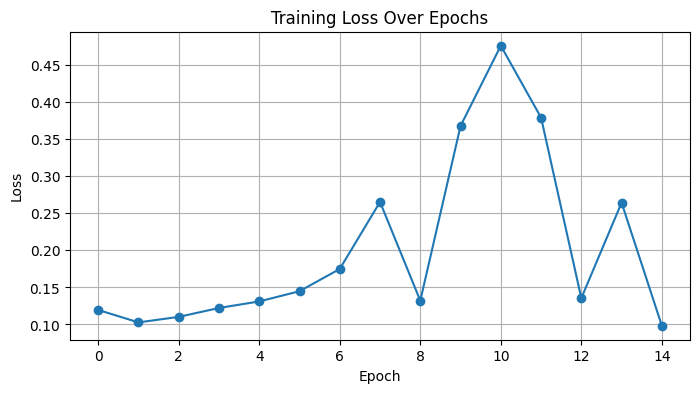

In [192]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


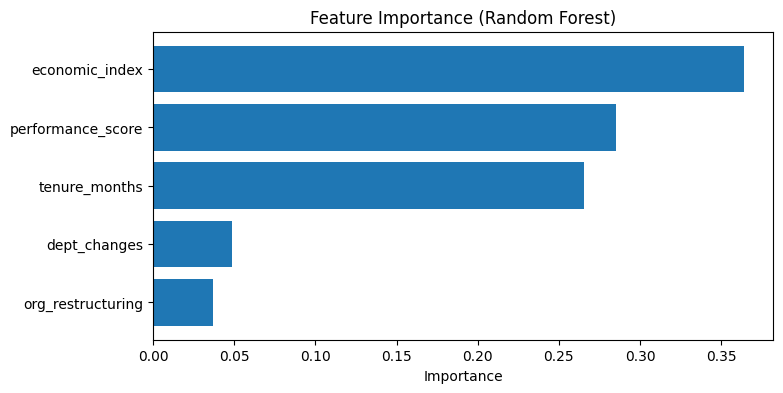

In [193]:
from sklearn.ensemble import RandomForestClassifier

# Create flattened dataset for RF
df_rf = df.groupby("employee_id").tail(1).copy()  # Use last row per employee
X_rf = df_rf[features]
y_rf = df_rf['laid_off']

rf = RandomForestClassifier()
rf.fit(X_rf, y_rf)

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()


In [194]:
torch.save(model.state_dict(), 'layoff_rnn_model.pth')


In [195]:
model = LayoffRNN(input_size=len(features), hidden_size=64)
model.load_state_dict(torch.load('layoff_rnn_model.pth'))
model.eval()


LayoffRNN(
  (rnn): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)